In [1]:
# load packages
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import json
import anndata as ad
import scanpy as sc

In [2]:
adata = sc.read_h5ad("/Users/mtong/Desktop/benchmark/southard_RPE1_CRISPRi/southard_data/perturb_processed.h5ad")
# 7,000 control cells, 71,566 total cells, 133 perturbations

In [3]:
# load split information
import json

with open("/Users/mtong/Desktop/benchmark/southard_RPE1_CRISPRi/southard_data/set2conditions.json") as f:
    set2conds = json.load(f)

# assuming you have a "test" key
test_conds = set2conds['test']  # this is a list of perturbation strings

# remove any '+ctrl' suffixes if present to align labeling with adata
test_conds = [c.replace('+ctrl','') for c in test_conds]

In [4]:
# paths
GEAR_out_dir = '/Users/mtong/Desktop/benchmark/southard_RPE1_CRISPRi/southard_data/GEARS'
scGPT_out_dir = '/Users/mtong/Desktop/benchmark/southard_RPE1_CRISPRi/southard_data/scGPT'
linear_out_dir = '/Users/mtong/Desktop/benchmark/southard_RPE1_CRISPRi/southard_data/linear'

# --- Load GEARS ---
with open(f"{GEAR_out_dir}/all_predictions.json", "r") as f:
    GEARS_all_pred_vals = json.load(f)
with open(f"{GEAR_out_dir}/all_ground_truth.json", "r") as f:
    GEARS_ground_truth_vals = json.load(f)
with open(f"{GEAR_out_dir}/gene_names.json", "r") as f:
    GEARS_gene_names = json.load(f)

# --- Load scGPT ---
with open(f"{scGPT_out_dir}/all_predictions.json", "r") as f:
    scGPT_all_pred_vals = json.load(f)
with open(f"{scGPT_out_dir}/gene_names.json", "r") as f:
    scGPT_gene_names = json.load(f)

# --- Load Linear ---
with open(f"{linear_out_dir}/all_predictions.json", "r") as f:
    linear_all_pred_vals = json.load(f)
with open(f"{linear_out_dir}/gene_names.json", "r") as f:
    linear_gene_names = json.load(f)

# --- Align conditions ---
conditions = sorted(GEARS_all_pred_vals.keys())
for d in [GEARS_ground_truth_vals, scGPT_all_pred_vals, linear_all_pred_vals]:
    assert set(d.keys()) >= set(conditions), "Some conditions missing in a dataset"

# --- Align genes ---
common_genes = sorted(
    list(set(GEARS_gene_names) & set(scGPT_gene_names) & set(linear_gene_names))
)
print(f"{len(common_genes)} genes are shared and will be used for alignment")

# Helper to build aligned matrices
def build_matrix(vals_dict, gene_names, conditions, genes_order):
    gene_idx = [gene_names.index(g) for g in genes_order]
    mat = np.vstack([[vals_dict[cond][i] for i in gene_idx] for cond in conditions])
    return mat

# Build matrices
GEARS_pred_mat = build_matrix(GEARS_all_pred_vals, GEARS_gene_names, conditions, common_genes)
gt_mat   = build_matrix(GEARS_ground_truth_vals, GEARS_gene_names, conditions, common_genes)
scGPT_pred_mat = build_matrix(scGPT_all_pred_vals, scGPT_gene_names, conditions, common_genes)
linear_pred_mat = build_matrix(linear_all_pred_vals, linear_gene_names, conditions, common_genes)

# --- Build AnnData ---
adata = ad.AnnData(
    X = gt_mat,  # default = ground truth
    obs = pd.DataFrame(index=conditions),
    var = pd.DataFrame(index=common_genes)
)

# Add layers
adata.layers["ground_truth"] = gt_mat
adata.layers["GEARS_predicted"]    = GEARS_pred_mat
adata.layers["scGPT_predicted"]    = scGPT_pred_mat
adata.layers["linear_predicted"]   = linear_pred_mat  # no ground truth for linear

# Add condition labels
adata.obs["condition"] = conditions

# Save AnnData if desired
# adata.write_h5ad("/Users/mtong/Desktop/benchmark/southard_RPE1_CRISPRi/southard_data/results_combined.h5ad")

5129 genes are shared and will be used for alignment


0.9976854542045414
0.9968876849114369
0.997246248214006


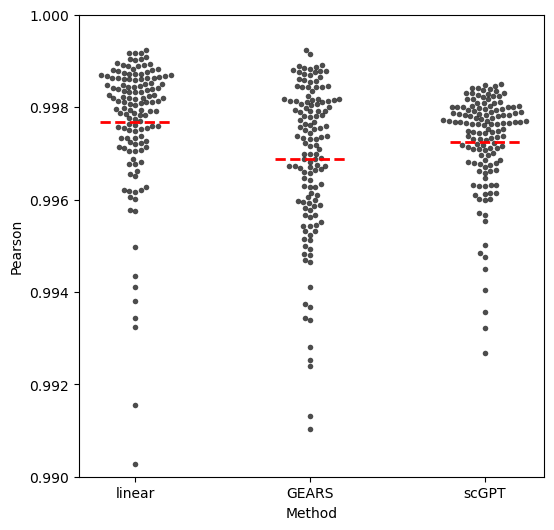

In [33]:
# Methods to compare
methods = ["linear_predicted", "scGPT_predicted", "GEARS_predicted"]
ground_truth_layer = "ground_truth"

# Prepare a tidy DataFrame
corr_records = []

for method in methods:
    for i, cond in enumerate(adata.obs_names):
        pred = adata.layers[method][i, :]
        gt   = adata.layers[ground_truth_layer][i, :]
        r, _ = pearsonr(pred, gt)
        corr_records.append({
            "condition": cond,
            "method": method.replace("_predicted", ""),
            "pearson_r": r
        })

corr_df = pd.DataFrame(corr_records)

# Filter out controls from the DataFrame
corr_df_1 = corr_df[corr_df["condition"] != "ctrl"]

# Plot violin plot
plt.figure(figsize=(6,6))

sns.swarmplot(
    data=corr_df_1,
    x="method",
    order=["linear", "GEARS", "scGPT"], 
    y="pearson_r",
    color="k",
    alpha=0.7,
    size=4
)

# Add lines per method
means = corr_df_1.groupby("method")["pearson_r"].mean()
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(means[method])

plt.ylabel("Pearson")
plt.xlabel("Method")
plt.ylim(0.99, 1)
plt.show()


In [5]:
# Identify the control condition
ctrl_cond = "ctrl"  # replace with the actual control name in your conditions list

# Find the index of the control condition
ctrl_idx = adata.obs.index.get_loc(ctrl_cond)

# Compute ctrl-subtracted matrices
xtruth_ctrl = adata.layers["ground_truth"] - adata.layers["ground_truth"][ctrl_idx, :]
GEARS_ctrl = adata.layers["GEARS_predicted"] - adata.layers["ground_truth"][ctrl_idx, :]  # subtract ctrl ground truth
scGPT_ctrl = adata.layers["scGPT_predicted"] - adata.layers["ground_truth"][ctrl_idx, :]
linear_ctrl = adata.layers["linear_predicted"] - adata.layers["ground_truth"][ctrl_idx, :]

# Add as new layers
adata.layers["truth_ctrl"] = xtruth_ctrl
adata.layers["GEARS_ctrl"] = GEARS_ctrl
adata.layers["scGPT_ctrl"] = scGPT_ctrl
adata.layers["linear_ctrl"] = linear_ctrl

/var/folders/mb/pmltjhs55y92fvp6z5t7q6j40000gp/T/ipykernel_34490/294090490.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(pred, gt)


0.6277680156734607
0.5643299420537256
0.5769678535193119


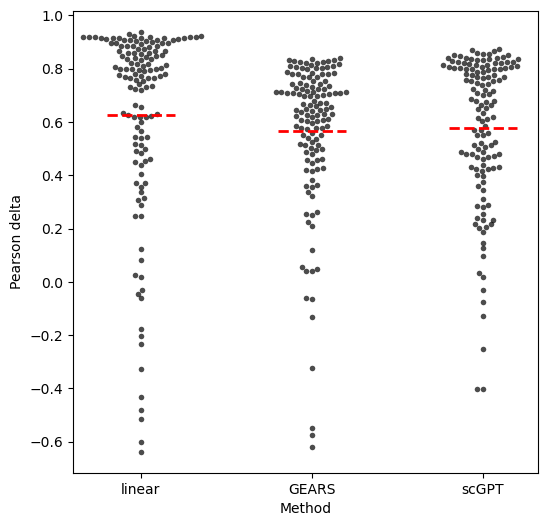

In [38]:
# Methods to compare
methods = ["linear_ctrl", "GEARS_ctrl", "scGPT_ctrl"]
ground_truth_layer = "truth_ctrl"

# Prepare a tidy DataFrame
corr_records = []

for method in methods:
    for i, cond in enumerate(adata.obs_names):
        pred = adata.layers[method][i, :]
        gt   = adata.layers[ground_truth_layer][i, :]
        r, _ = pearsonr(pred, gt)
        corr_records.append({
            "condition": cond,
            "method": method.replace("_ctrl", ""),
            "pearson_r": r
        })

corr_df = pd.DataFrame(corr_records)

# Filter out controls from the DataFrame
corr_df_2 = corr_df[corr_df["condition"] != "ctrl"]

# Plot violin plot
plt.figure(figsize=(6,6))

sns.swarmplot(
    data=corr_df_2,
    x="method",
    order=["linear", "GEARS", "scGPT"], 
    y="pearson_r",
    color="k",
    alpha=0.7,
    size=4
)

# Add lines per method
means = corr_df_2.groupby("method")["pearson_r"].mean()
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(means[method])

plt.ylabel("Pearson delta")
plt.xlabel("Method")
plt.show()


linear 0.5376684893893876
GEARS 0.4417707241582466
scGPT 0.47301443720435427


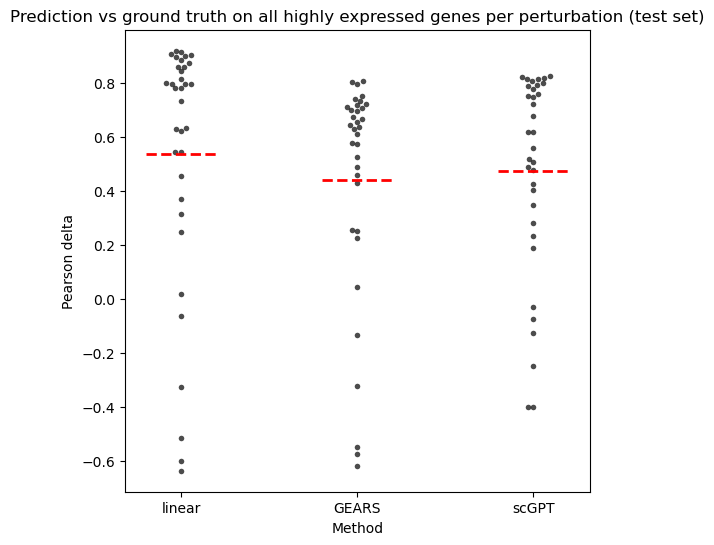

In [36]:
# Methods to compare
methods = ["linear_ctrl", "GEARS_ctrl", "scGPT_ctrl"]
ground_truth_layer = "truth_ctrl"

# Prepare a tidy DataFrame
corr_records = []

# Loop only over test conditions
for method in methods:
    for i, cond in enumerate(adata.obs_names):
        if cond not in test_conds:  # <-- only test perturbations
            continue
        pred = adata.layers[method][i, :]
        gt   = adata.layers[ground_truth_layer][i, :]
        r, _ = pearsonr(pred, gt)
        corr_records.append({
            "condition": cond,
            "method": method.replace("_ctrl", ""),
            "pearson_r": r
        })

corr_df = pd.DataFrame(corr_records)

# Filter out controls just in case
corr_df_filtered = corr_df[corr_df["condition"] != "ctrl"]

# Plot violin/swarm plot
plt.figure(figsize=(6,6))

sns.swarmplot(
    data=corr_df_filtered,
    x="method",
    order=["linear", "GEARS", "scGPT"], 
    y="pearson_r",
    color="k",
    alpha=0.7,
    size=4
)

# Add horizontal mean lines per method
means = corr_df_filtered.groupby("method")["pearson_r"].mean()
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(method, means[method])

plt.title("Prediction vs ground truth on all highly expressed genes per perturbation (test set)")
plt.ylabel("Pearson delta")
plt.xlabel("Method")
plt.show()


2.5463682183427596
3.0190568085519893
2.960455298840742


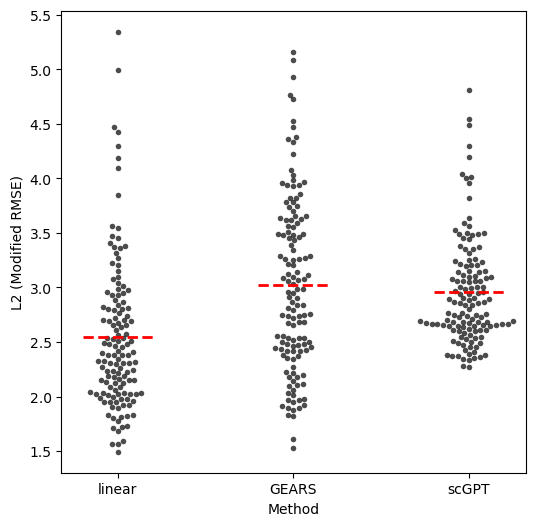

In [39]:
# Methods to compare
methods = ["linear_ctrl", "GEARS_ctrl", "scGPT_ctrl"]
ground_truth_layer = "truth_ctrl"

# Prepare a tidy DataFrame
rmse_records = []

for method in methods:
    for i, cond in enumerate(adata.obs_names):
        if cond == "ctrl":
            continue  # skip control
        pred = adata.layers[method][i, :]
        gt   = adata.layers[ground_truth_layer][i, :]
        
        # RMSE formula
        rmse = np.sqrt(np.sum((pred - gt)**2))
        
        rmse_records.append({
            "condition": cond,
            "method": method.replace("_ctrl", ""),
            "rmse": rmse
        })

rmse_df = pd.DataFrame(rmse_records)

plt.figure(figsize=(6,6))

sns.swarmplot(
    data=rmse_df,
    x="method",
    y="rmse",
    order=["linear", "GEARS", "scGPT"],
    color="k",
    alpha=0.7,
    size=4
)

# Add mean RMSE lines per method
means = rmse_df.groupby("method")["rmse"].mean()
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(means[method])

plt.ylabel("L2 (Modified RMSE)")
plt.xlabel("Method")
plt.show()


# Differential Expression Analysis

In [40]:
import pandas as pd

In [41]:
de_df = pd.read_csv("/Users/mtong/Desktop/benchmark/southard_RPE1_CRISPRi/southard_data/DE_analysis.csv")
# Remove '+ctrl' from all entries in the 'group' column
de_df['group_old'] = de_df['group']
de_df['group'] = de_df['group'].str.replace(r'\+ctrl$', '', regex=True)

In [42]:
top_genes_dict = {}

# Loop over each perturbation condition (group)
for group in de_df['group'].unique():
    # Subset for this group
    group_df = de_df[de_df['group'] == group]
    
    # Filter significant genes
    sig_df = group_df[group_df['pvals_adj'] <= 0.05]
    
    # Sort by absolute logfoldchange (largest first)
    sig_df = sig_df.reindex(sig_df['logfoldchanges'].abs().sort_values(ascending=False).index)
    
    # Take top 20
    top20 = sig_df.head(20)
    
    # Store in dictionary
    top_genes_dict[group] = top20

In [44]:
# Initialize results dataframe
corr_df = pd.DataFrame(index=conditions, columns=["GEARS", "scGPT", "linear"])

# Loop over each perturbation / condition
for cond in conditions:
    if cond == 'ctrl':
        continue  # skip 'ctrl'

    # Get top 20 genes for this condition
    top_genes_df = top_genes_dict[cond]  # this is already a DataFrame
    top_genes = top_genes_df["gene_name"].head(20).tolist()

    # Keep only genes that exist in common_genes
    top_genes = [g for g in top_genes if g in common_genes]

    # Get indices in var_names
    gene_idx = [adata.var_names.get_loc(g) for g in top_genes]

    # Select cells for this perturbation
    cell_idx = adata.obs["condition"] == cond

    # Extract averaged prediction and ground truth vectors for this condition
    GEARS_pred = adata.layers["GEARS_predicted"][cell_idx][:, gene_idx].mean(axis=0)
    GEARS_gt   = adata.layers["ground_truth"][cell_idx][:, gene_idx].mean(axis=0)

    scGPT_pred = adata.layers["scGPT_predicted"][cell_idx][:, gene_idx].mean(axis=0)
    scGPT_gt   = adata.layers["ground_truth"][cell_idx][:, gene_idx].mean(axis=0)

    linear_pred = adata.layers["linear_predicted"][cell_idx][:, gene_idx].mean(axis=0)

    # Compute Pearson correlations
    if len(GEARS_pred) >= 20:
        corr_df.loc[cond, "GEARS"] = pearsonr(GEARS_pred, GEARS_gt)[0]
    else:
        print("Warning: Not enough DE genes for GEARS in condition", cond)

    if len(scGPT_pred) >= 20:
        corr_df.loc[cond, "scGPT"] = pearsonr(scGPT_pred, scGPT_gt)[0]
    else:
        print("Warning: Not enough DE genes for scGPT in condition", cond)

    if len(linear_pred) >= 20:
        corr_df.loc[cond, "linear"] = pearsonr(linear_pred, scGPT_gt)[0]
    else:
        print("Warning: Not enough DE genes for linear in condition", cond)

# Convert to float
corr_df = corr_df.astype(float)

In [45]:
# filter out conditions without 20 DE genes
corr_df_plot = corr_df.dropna()


In [46]:
len(corr_df)


134

In [47]:
len(corr_df_plot)

123

In [48]:
# Melt into long format
corr_long = corr_df_plot.reset_index().melt(
    id_vars='index',      # this is your condition column
    value_vars=['GEARS', 'scGPT', 'linear'],
    var_name='method',
    value_name='pearson_r'
)
corr_long = corr_long.rename(columns={'index': 'condition'})

/Users/mtong/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mtong/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mtong/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mtong/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 18.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0.9034727388284609
0.903036550905894
0.9220597834579488


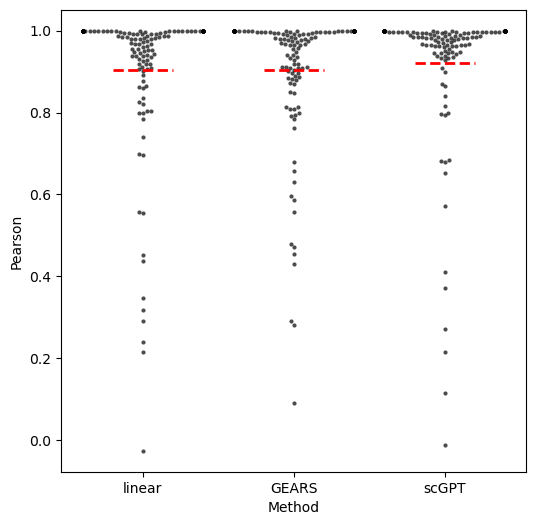

In [51]:
# Calculate the mean pearson_r for each method
means = corr_long.groupby("method")["pearson_r"].mean()

plt.figure(figsize=(6,6))

sns.swarmplot(
    data=corr_long,
    x="method",
    order=["linear", "GEARS", "scGPT"],
    y="pearson_r",
    color="k",
    alpha=0.7,
    size=3
)

# Add horizontal lines at the mean for each method (after swarmplot)
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(means[method])

plt.ylabel("Pearson")
plt.xlabel("Method")
plt.show()

linear 0.8936146984196139
GEARS 0.9041751757051364
scGPT 0.9087978927864863


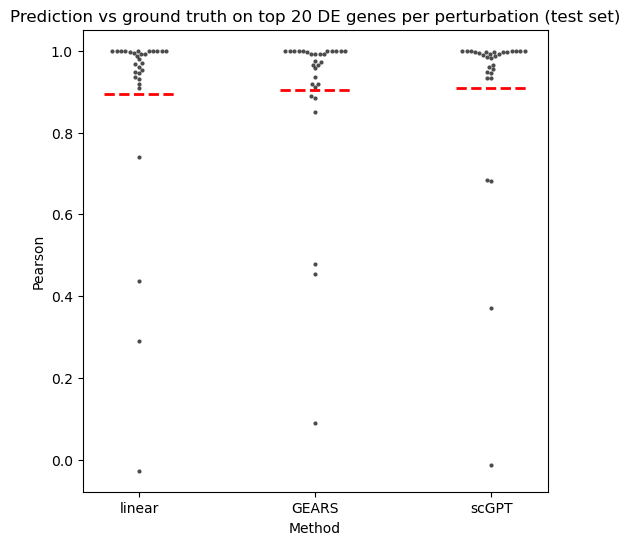

In [52]:
# Filter to only test conditions
corr_long_test = corr_long[corr_long["condition"].isin(test_conds)]

# Calculate the mean pearson_r for each method
means = corr_long_test.groupby("method")["pearson_r"].mean()

plt.figure(figsize=(6,6))

sns.swarmplot(
    data=corr_long_test,
    x="method",
    order=["linear", "GEARS", "scGPT"],
    y="pearson_r",
    color="k",
    alpha=0.7,
    size=3
)

# Add horizontal lines at the mean for each method
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(method, means[method])

plt.title("Prediction vs ground truth on top 20 DE genes per perturbation (test set)")
plt.ylabel("Pearson")
plt.xlabel("Method")
plt.show()


In [55]:
# Initialize results dataframe
corr_df = pd.DataFrame(index=conditions, columns=["GEARS", "scGPT", "linear"])

# Loop over each perturbation / condition
for cond in conditions:
    if cond == 'ctrl':
        continue  # skip 'ctrl'

    # Get top 20 genes for this condition
    top_genes_df = top_genes_dict[cond]  # this is already a DataFrame
    top_genes = top_genes_df["gene_name"].head(20).tolist()

    # Keep only genes that exist in common_genes
    top_genes = [g for g in top_genes if g in common_genes]

    # Get indices in var_names
    gene_idx = [adata.var_names.get_loc(g) for g in top_genes]

    # Select cells for this perturbation
    cell_idx = adata.obs["condition"] == cond

    # Extract averaged prediction and ground truth vectors for this condition
    GEARS_pred = adata.layers["GEARS_ctrl"][cell_idx][:, gene_idx].mean(axis=0)
    GEARS_gt   = adata.layers["truth_ctrl"][cell_idx][:, gene_idx].mean(axis=0)

    scGPT_pred = adata.layers["scGPT_ctrl"][cell_idx][:, gene_idx].mean(axis=0)
    scGPT_gt   = adata.layers["truth_ctrl"][cell_idx][:, gene_idx].mean(axis=0)

    linear_pred = adata.layers["linear_ctrl"][cell_idx][:, gene_idx].mean(axis=0)

    # Compute Pearson correlations
    if len(GEARS_pred) >= 20:
        corr_df.loc[cond, "GEARS"] = pearsonr(GEARS_pred, GEARS_gt)[0]
    else:
        print("Warning: Not enough DE genes for GEARS in condition", cond)

    if len(scGPT_pred) >= 20:
        corr_df.loc[cond, "scGPT"] = pearsonr(scGPT_pred, scGPT_gt)[0]
    else:
        print("Warning: Not enough DE genes for scGPT in condition", cond)

    if len(linear_pred) >= 20:
        corr_df.loc[cond, "linear"] = pearsonr(linear_pred, scGPT_gt)[0]
    else:
        print("Warning: Not enough DE genes for linear in condition", cond)

# Convert to float
corr_df = corr_df.astype(float)

In [56]:
# filter out conditions without 20 DE genes
corr_df_plot = corr_df.dropna()


In [58]:
# Melt into long format
corr_long = corr_df_plot.reset_index().melt(
    id_vars='index',      # this is your condition column
    value_vars=['GEARS', 'scGPT', 'linear'],
    var_name='method',
    value_name='pearson_r'
)
corr_long = corr_long.rename(columns={'index': 'condition'})

0.3479158295329413
0.3802051284731511
0.8150051622801365


/Users/mtong/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mtong/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 17.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


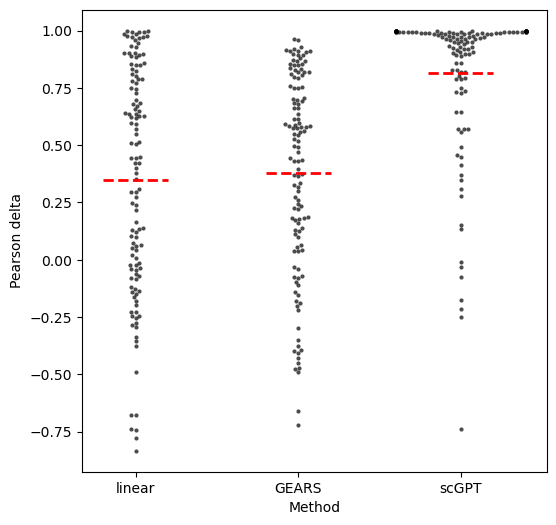

In [61]:
# Calculate the mean pearson_r for each method
means = corr_long.groupby("method")["pearson_r"].mean()

plt.figure(figsize=(6,6))

sns.swarmplot(
    data=corr_long,
    x="method",
    order=["linear", "GEARS", "scGPT"],
    y="pearson_r",
    color="k",
    alpha=0.7,
    size=3
)

# Add horizontal lines at the mean for each method (after swarmplot)
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(means[method])

plt.ylabel("Pearson delta")
plt.xlabel("Method")
plt.show()

0.8935750902776648
0.8864247870157341
0.43196238456472186


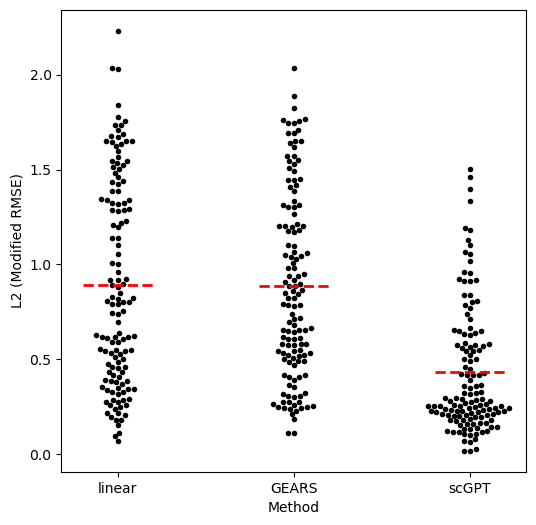

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize RMSE dataframe
rmse_df = pd.DataFrame(index=conditions, columns=["GEARS", "scGPT", "linear"])

# Loop over each perturbation / condition
for cond in conditions:
    if cond == 'ctrl':
        continue  # skip control
    # Get top 20 DE genes
    top_genes_df = top_genes_dict[cond]
    top_genes = top_genes_df["gene_name"].head(20).tolist()
    top_genes = [g for g in top_genes if g in common_genes]

    # Get indices
    gene_idx = [adata.var_names.get_loc(g) for g in top_genes]

    # Extract predictions and ground truth (ctrl-subtracted)
    GEARS_pred = adata.layers["GEARS_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    GEARS_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    scGPT_pred = adata.layers["scGPT_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    scGPT_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    linear_pred = adata.layers["linear_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    # Compute RMSE
    rmse_df.loc[cond, "GEARS"] = np.sqrt(np.sum((GEARS_pred - GEARS_gt)**2))
    rmse_df.loc[cond, "scGPT"] = np.sqrt(np.sum((scGPT_pred - scGPT_gt)**2))
    rmse_df.loc[cond, "linear"] = np.sqrt(np.sum((linear_pred - scGPT_gt)**2))  # linear GT = scGPT GT

# Convert to float
rmse_df = rmse_df.astype(float)

# Remove 'ctrl' row if present
rmse_df = rmse_df.drop(index='ctrl', errors='ignore')

# Melt to long format for plotting
rmse_long = rmse_df.reset_index().melt(
    id_vars='index',
    value_vars=['GEARS', 'scGPT', 'linear'],
    var_name='method',
    value_name='RMSE'
)
rmse_long = rmse_long.rename(columns={'index': 'condition'})

# --- Plotting ---
plt.figure(figsize=(6,6))
import seaborn as sns

sns.swarmplot(
    data=rmse_long,
    x="method",
    y="RMSE",
    color="k",
    order=["linear", "GEARS", "scGPT"],
    size=4
)

# Add horizontal lines for mean RMSE per method
means = rmse_long.groupby("method")["RMSE"].mean()
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(means[method])

plt.ylabel("L2 (Modified RMSE)")
plt.xlabel("Method")
plt.show()


### top 100

In [62]:
de_df = pd.read_csv("/Users/mtong/Desktop/benchmark/southard_RPE1_CRISPRi/southard_data/DE_analysis.csv")
# Remove '+ctrl' from all entries in the 'group' column
de_df['group_old'] = de_df['group']
de_df['group'] = de_df['group'].str.replace(r'\+ctrl$', '', regex=True)

In [63]:
top_genes_dict = {}

# Loop over each perturbation condition (group)
for group in de_df['group'].unique():
    # Subset for this group
    group_df = de_df[de_df['group'] == group]
    
    # Filter significant genes
    sig_df = group_df[group_df['pvals_adj'] <= 0.05]
    
    # Sort by absolute logfoldchange (largest first)
    sig_df = sig_df.reindex(sig_df['logfoldchanges'].abs().sort_values(ascending=False).index)
    
    # Take top 100
    top100 = sig_df.head(100)
    
    # Store in dictionary
    top_genes_dict[group] = top100

In [64]:
# Initialize results dataframe
corr_df = pd.DataFrame(index=conditions, columns=["GEARS", "scGPT", "linear"])

# Loop over each perturbation / condition
for cond in conditions:
    if cond == 'ctrl':
        continue  # skip 'ctrl'

    # Get top 100 genes for this condition
    top_genes_df = top_genes_dict[cond]  # this is already a DataFrame
    top_genes = top_genes_df["gene_name"].head(100).tolist()

    # Keep only genes that exist in common_genes
    top_genes = [g for g in top_genes if g in common_genes]

    # Get indices in var_names
    gene_idx = [adata.var_names.get_loc(g) for g in top_genes]

    # Select cells for this perturbation
    cell_idx = adata.obs["condition"] == cond

    # Extract averaged prediction and ground truth vectors for this condition
    GEARS_pred = adata.layers["GEARS_predicted"][cell_idx][:, gene_idx].mean(axis=0)
    GEARS_gt   = adata.layers["ground_truth"][cell_idx][:, gene_idx].mean(axis=0)

    scGPT_pred = adata.layers["scGPT_predicted"][cell_idx][:, gene_idx].mean(axis=0)
    scGPT_gt   = adata.layers["ground_truth"][cell_idx][:, gene_idx].mean(axis=0)

    linear_pred = adata.layers["linear_predicted"][cell_idx][:, gene_idx].mean(axis=0)

    # Compute Pearson correlations
    if len(GEARS_pred) >= 100:
        corr_df.loc[cond, "GEARS"] = pearsonr(GEARS_pred, GEARS_gt)[0]
    else:
        print("Warning: Not enough genes for GEARS in condition", cond)

    if len(scGPT_pred) >= 100:
        corr_df.loc[cond, "scGPT"] = pearsonr(scGPT_pred, scGPT_gt)[0]
    else:
        print("Warning: Not enough genes for GEARS in condition", cond)

    if len(linear_pred) >= 100:
        corr_df.loc[cond, "linear"] = pearsonr(linear_pred, scGPT_gt)[0]
    else:
        print("Warning: Not enough genes for GEARS in condition", cond)

# Convert to float
corr_df = corr_df.astype(float)

In [65]:
# filter out conditions without 20 DE genes
corr_df_plot = corr_df.dropna()

In [66]:
len(corr_df_plot)

110

In [67]:
# Melt into long format
corr_long = corr_df_plot.reset_index().melt(
    id_vars='index',      # this is your condition column
    value_vars=['GEARS', 'scGPT', 'linear'],
    var_name='method',
    value_name='pearson_r'
)
corr_long = corr_long.rename(columns={'index': 'condition'})

0.9706312087003512
0.9671173962367922
0.9807645750871887


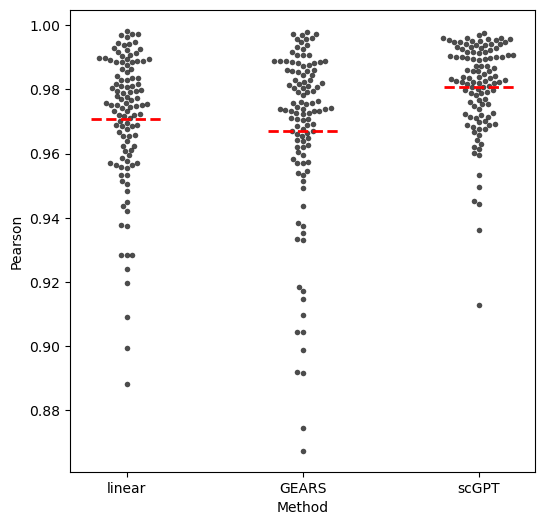

In [69]:
# Calculate the mean pearson_r for each method
means = corr_long.groupby("method")["pearson_r"].mean()

plt.figure(figsize=(6,6))

sns.swarmplot(
    data=corr_long,
    x="method",
    order=["linear", "GEARS", "scGPT"],
    y="pearson_r",
    color="k",
    alpha=0.7,
    size=4
)

# Add horizontal lines at the mean for each method (after swarmplot)
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(means[method])

plt.ylabel("Pearson")
plt.xlabel("Method")
plt.show()

In [72]:
top_genes_dict = {}

# Loop over each perturbation condition (group)
for group in de_df['group'].unique():
    # Subset for this group
    group_df = de_df[de_df['group'] == group]
    
    # Filter significant genes
    sig_df = group_df[group_df['pvals_adj'] <= 0.05]
    
    # Sort by absolute logfoldchange (largest first)
    sig_df = sig_df.reindex(sig_df['logfoldchanges'].abs().sort_values(ascending=False).index)
    
    # Take top 100
    top100 = sig_df.head(100)
    
    # Store in dictionary
    top_genes_dict[group] = top100

# Initialize results dataframe
corr_df = pd.DataFrame(index=conditions, columns=["GEARS", "scGPT", "linear"])

# Loop over each perturbation / condition
for cond in conditions:
    if cond == 'ctrl':
        continue  # skip 'ctrl'

    # Get top 20 genes for this condition
    top_genes_df = top_genes_dict[cond]  # this is already a DataFrame
    top_genes = top_genes_df["gene_name"].head(100).tolist()

    # Keep only genes that exist in common_genes
    top_genes = [g for g in top_genes if g in common_genes]

    # Get indices in var_names
    gene_idx = [adata.var_names.get_loc(g) for g in top_genes]

    # Select cells for this perturbation
    cell_idx = adata.obs["condition"] == cond

    # Extract averaged prediction and ground truth vectors for this condition
    GEARS_pred = adata.layers["GEARS_ctrl"][cell_idx][:, gene_idx].mean(axis=0)
    GEARS_gt   = adata.layers["truth_ctrl"][cell_idx][:, gene_idx].mean(axis=0)

    scGPT_pred = adata.layers["scGPT_ctrl"][cell_idx][:, gene_idx].mean(axis=0)
    scGPT_gt   = adata.layers["truth_ctrl"][cell_idx][:, gene_idx].mean(axis=0)

    linear_pred = adata.layers["linear_ctrl"][cell_idx][:, gene_idx].mean(axis=0)

    # Compute Pearson correlations
    if len(GEARS_pred) >= 100:
        corr_df.loc[cond, "GEARS"] = pearsonr(GEARS_pred, GEARS_gt)[0]
    else:
        print("Warning: Not enough genes for GEARS in condition", cond)

    if len(scGPT_pred) >= 100:
        corr_df.loc[cond, "scGPT"] = pearsonr(scGPT_pred, scGPT_gt)[0]
    else:
        print("Warning: Not enough genes for GEARS in condition", cond)

    if len(linear_pred) >= 100:
        corr_df.loc[cond, "linear"] = pearsonr(linear_pred, scGPT_gt)[0]
    else:
        print("Warning: Not enough genes for GEARS in condition", cond)

# Convert to float
corr_df = corr_df.astype(float)

In [73]:
# filter out conditions without 20 DE genes
corr_df_plot = corr_df.dropna()
# Melt into long format
corr_long = corr_df_plot.reset_index().melt(
    id_vars='index',      # this is your condition column
    value_vars=['GEARS', 'scGPT', 'linear'],
    var_name='method',
    value_name='pearson_r'
)
corr_long = corr_long.rename(columns={'index': 'condition'})

0.687092184386789
0.6695442797571126
0.7735900734403874


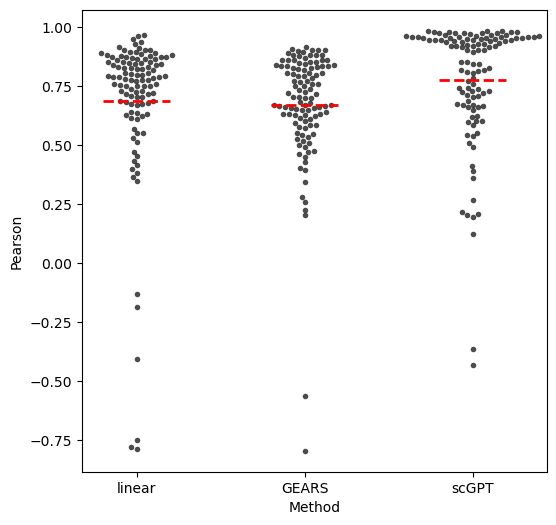

In [74]:
# Calculate the mean pearson_r for each method
means = corr_long.groupby("method")["pearson_r"].mean()

plt.figure(figsize=(6,6))

sns.swarmplot(
    data=corr_long,
    x="method",
    order=["linear", "GEARS", "scGPT"],
    y="pearson_r",
    color="k",
    alpha=0.7,
    size=4
)

# Add horizontal lines at the mean for each method (after swarmplot)
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(means[method])

plt.ylabel("Pearson")
plt.xlabel("Method")
plt.show()

1.317462856517171
1.3934234856192902
1.0627495569572127


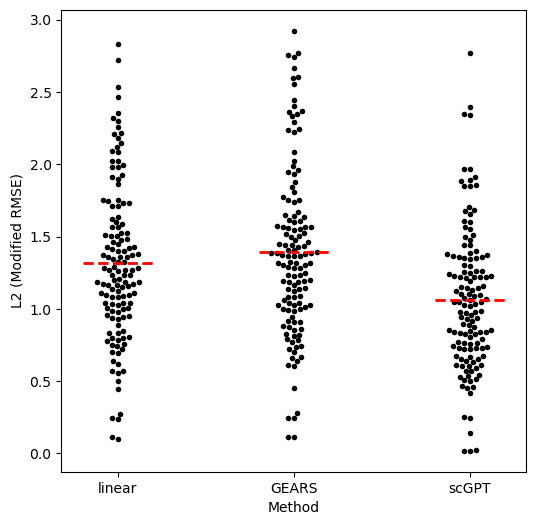

In [75]:
# Initialize RMSE dataframe
rmse_df = pd.DataFrame(index=conditions, columns=["GEARS", "scGPT", "linear"])

# Loop over each perturbation / condition
for cond in conditions:
    if cond == 'ctrl':
        continue  # skip control
    # Get top 100 DE genes
    top_genes_df = top_genes_dict[cond]
    top_genes = top_genes_df["gene_name"].head(100).tolist()
    top_genes = [g for g in top_genes if g in common_genes]

    # Get indices
    gene_idx = [adata.var_names.get_loc(g) for g in top_genes]

    # Extract predictions and ground truth (ctrl-subtracted)
    GEARS_pred = adata.layers["GEARS_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    GEARS_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    scGPT_pred = adata.layers["scGPT_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    scGPT_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    linear_pred = adata.layers["linear_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    # Compute RMSE
    rmse_df.loc[cond, "GEARS"] = np.sqrt(np.sum((GEARS_pred - GEARS_gt)**2))
    rmse_df.loc[cond, "scGPT"] = np.sqrt(np.sum((scGPT_pred - scGPT_gt)**2))
    rmse_df.loc[cond, "linear"] = np.sqrt(np.sum((linear_pred - scGPT_gt)**2))  # linear GT = scGPT GT

# Convert to float
rmse_df = rmse_df.astype(float)

# Remove 'ctrl' row if present
rmse_df = rmse_df.drop(index='ctrl', errors='ignore')

# Melt to long format for plotting
rmse_long = rmse_df.reset_index().melt(
    id_vars='index',
    value_vars=['GEARS', 'scGPT', 'linear'],
    var_name='method',
    value_name='RMSE'
)
rmse_long = rmse_long.rename(columns={'index': 'condition'})

# --- Plotting ---
plt.figure(figsize=(6,6))
import seaborn as sns

sns.swarmplot(
    data=rmse_long,
    x="method",
    y="RMSE",
    color="k",
    order=["linear", "GEARS", "scGPT"],
    size=4
)

# Add horizontal lines for mean RMSE per method
means = rmse_long.groupby("method")["RMSE"].mean()
ax = plt.gca()
for i, method in enumerate(["linear", "GEARS", "scGPT"]):
    ax.hlines(
        y=means[method], xmin=i - 0.2, xmax=i + 0.2, color="red", linestyle="--", linewidth=2, zorder=3
    )
    print(means[method])

plt.ylabel("L2 (Modified RMSE)")
plt.xlabel("Method")
plt.show()


In [101]:
top_genes_dict = {}

# Loop over each perturbation condition (group)
for group in de_df['group'].unique():
    # Subset for this group
    group_df = de_df[de_df['group'] == group]
    
    # Filter significant genes
    sig_df = group_df[group_df['pvals_adj'] <= 0.05]
    
    # Sort by absolute logfoldchange (largest first)
    sig_df = sig_df.reindex(sig_df['logfoldchanges'].abs().sort_values(ascending=False).index)
    
    # Take top 20
    top20 = sig_df.head(20)
    
    # Store in dictionary
    top_genes_dict[group] = top20

Skipping GPN2 due to fewer than 20 DE genes.
Skipping GTF2E1 due to fewer than 20 DE genes.
Skipping GTF2F2 due to fewer than 20 DE genes.
Skipping NUP214 due to fewer than 20 DE genes.
Skipping RPTOR due to fewer than 20 DE genes.
Skipping TMX2 due to fewer than 20 DE genes.
Skipping TYK2 due to fewer than 20 DE genes.
Skipping URI1 due to fewer than 20 DE genes.
Skipping XRCC5 due to fewer than 20 DE genes.
Skipping XRCC6 due to fewer than 20 DE genes.


/var/folders/mb/pmltjhs55y92fvp6z5t7q6j40000gp/T/ipykernel_34490/2673747981.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


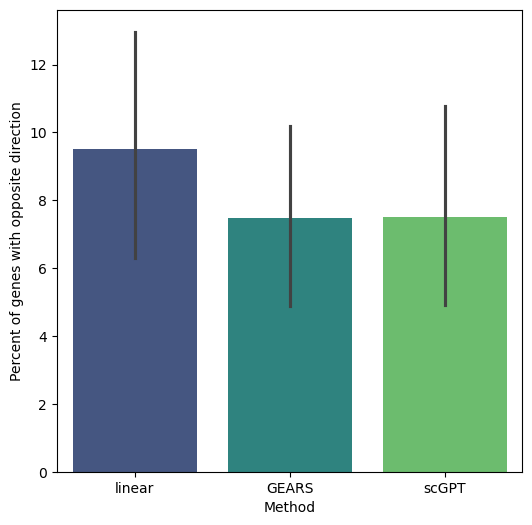

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a dictionary to store percentages
percent_correct = {"GEARS": [], "scGPT": [], "linear": []}
# Initialize a list to track valid conditions
valid_conditions = []

# Loop over each perturbation / condition
for cond in conditions:
    if cond == 'ctrl':
        continue  # skip control

    # Get top 20 DE genes
    top_genes_df = top_genes_dict[cond]
    
    # Skip if there are fewer than 20 DE genes
    if len(top_genes_df) < 20:
        print(f"Skipping {cond} due to fewer than 20 DE genes.")
        continue

    valid_conditions.append(cond)  # Add to valid conditions

    top_genes = top_genes_df["gene_name"].head(20).tolist()
    top_genes = [g for g in top_genes if g in common_genes]

    # Get indices
    gene_idx = [adata.var_names.get_loc(g) for g in top_genes]

    # Extract predictions and ground truth (ctrl-subtracted)
    GEARS_pred = adata.layers["GEARS_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    GEARS_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    scGPT_pred = adata.layers["scGPT_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    scGPT_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    linear_pred = adata.layers["linear_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    linear_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    # Compute the percentage of predictions in the correct direction
    percent_correct["GEARS"].append(
        np.mean(np.sign(GEARS_pred) == np.sign(GEARS_gt)) * 100
    )
    percent_correct["scGPT"].append(
        np.mean(np.sign(scGPT_pred) == np.sign(scGPT_gt)) * 100
    )
    percent_correct["linear"].append(
        np.mean(np.sign(linear_pred) == np.sign(linear_gt)) * 100
    )

# Compute the percentage of predictions in the opposite direction
percent_opposite = {
    "GEARS": [100 - val for val in percent_correct["GEARS"]],
    "scGPT": [100 - val for val in percent_correct["scGPT"]],
    "linear": [100 - val for val in percent_correct["linear"]]
}

# Convert to DataFrame for plotting
percent_opposite_df = pd.DataFrame(percent_opposite, index=valid_conditions)

# Melt to long format for plotting
percent_opposite_long = percent_opposite_df.reset_index().melt(
    id_vars='index',
    value_vars=['GEARS', 'scGPT', 'linear'],
    var_name='method',
    value_name='Percent Opposite'
)

# --- Plotting ---
plt.figure(figsize=(6, 6))
sns.barplot(
    data=percent_opposite_long,
    x="method",
    y="Percent Opposite",
    order=["linear", "GEARS", "scGPT"],
    palette="viridis"
)
plt.ylabel("Percent of genes with opposite direction")
plt.xlabel("Method")
plt.show()

In [104]:
top_genes_dict = {}

# Loop over each perturbation condition (group)
for group in de_df['group'].unique():
    # Subset for this group
    group_df = de_df[de_df['group'] == group]
    
    # Filter significant genes
    sig_df = group_df[group_df['pvals_adj'] <= 0.05]
    
    # Sort by absolute logfoldchange (largest first)
    sig_df = sig_df.reindex(sig_df['logfoldchanges'].abs().sort_values(ascending=False).index)
    
    # Take top 100
    top100 = sig_df.head(100)
    
    # Store in dictionary
    top_genes_dict[group] = top100

Skipping ERCC3 due to fewer than 100 DE genes.
Skipping EXOSC2 due to fewer than 100 DE genes.
Skipping GPN2 due to fewer than 100 DE genes.
Skipping GTF2E1 due to fewer than 100 DE genes.
Skipping GTF2E2 due to fewer than 100 DE genes.
Skipping GTF2F2 due to fewer than 100 DE genes.
Skipping MED11 due to fewer than 100 DE genes.
Skipping NUP133 due to fewer than 100 DE genes.
Skipping NUP214 due to fewer than 100 DE genes.
Skipping NUP54 due to fewer than 100 DE genes.
Skipping POGLUT3 due to fewer than 100 DE genes.
Skipping POLR3E due to fewer than 100 DE genes.
Skipping PPP2CB due to fewer than 100 DE genes.
Skipping RPTOR due to fewer than 100 DE genes.
Skipping TAF10 due to fewer than 100 DE genes.
Skipping TAF6 due to fewer than 100 DE genes.
Skipping TANGO6 due to fewer than 100 DE genes.
Skipping TMX2 due to fewer than 100 DE genes.
Skipping TYK2 due to fewer than 100 DE genes.
Skipping URI1 due to fewer than 100 DE genes.
Skipping UXT due to fewer than 100 DE genes.
Skipping 

/var/folders/mb/pmltjhs55y92fvp6z5t7q6j40000gp/T/ipykernel_34490/3647973336.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


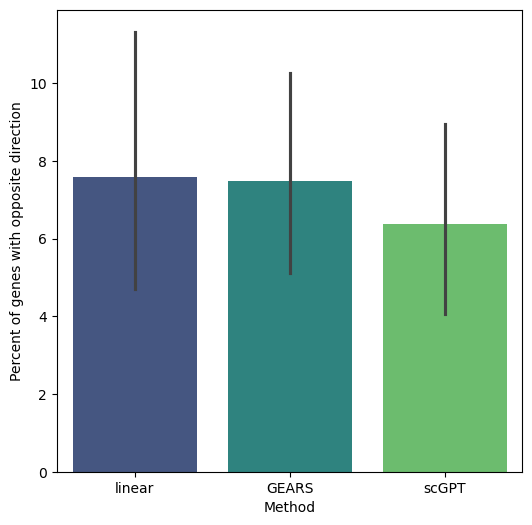

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a dictionary to store percentages
percent_correct = {"GEARS": [], "scGPT": [], "linear": []}
# Initialize a list to track valid conditions
valid_conditions = []

# Loop over each perturbation / condition
for cond in conditions:
    if cond == 'ctrl':
        continue  # skip control

    # Get top 100 DE genes
    top_genes_df = top_genes_dict[cond]
    
    # Skip if there are fewer than 100 DE genes
    if len(top_genes_df) < 100:
        print(f"Skipping {cond} due to fewer than 100 DE genes.")
        continue

    valid_conditions.append(cond)  # Add to valid conditions

    top_genes = top_genes_df["gene_name"].head(100).tolist()
    top_genes = [g for g in top_genes if g in common_genes]

    # Get indices
    gene_idx = [adata.var_names.get_loc(g) for g in top_genes]

    # Extract predictions and ground truth (ctrl-subtracted)
    GEARS_pred = adata.layers["GEARS_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    GEARS_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    scGPT_pred = adata.layers["scGPT_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    scGPT_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    linear_pred = adata.layers["linear_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    linear_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    # Compute the percentage of predictions in the correct direction
    percent_correct["GEARS"].append(
        np.mean(np.sign(GEARS_pred) == np.sign(GEARS_gt)) * 100
    )
    percent_correct["scGPT"].append(
        np.mean(np.sign(scGPT_pred) == np.sign(scGPT_gt)) * 100
    )
    percent_correct["linear"].append(
        np.mean(np.sign(linear_pred) == np.sign(linear_gt)) * 100
    )

# Compute the percentage of predictions in the opposite direction
percent_opposite = {
    "GEARS": [100 - val for val in percent_correct["GEARS"]],
    "scGPT": [100 - val for val in percent_correct["scGPT"]],
    "linear": [100 - val for val in percent_correct["linear"]]
}

# Convert to DataFrame for plotting
percent_opposite_df = pd.DataFrame(percent_opposite, index=valid_conditions)

# Melt to long format for plotting
percent_opposite_long = percent_opposite_df.reset_index().melt(
    id_vars='index',
    value_vars=['GEARS', 'scGPT', 'linear'],
    var_name='method',
    value_name='Percent Opposite'
)

# --- Plotting ---
plt.figure(figsize=(6, 6))
sns.barplot(
    data=percent_opposite_long,
    x="method",
    y="Percent Opposite",
    order=["linear", "GEARS", "scGPT"],
    palette="viridis"
)
plt.ylabel("Percent of genes with opposite direction")
plt.xlabel("Method")
plt.show()

/var/folders/mb/pmltjhs55y92fvp6z5t7q6j40000gp/T/ipykernel_34490/1761852097.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


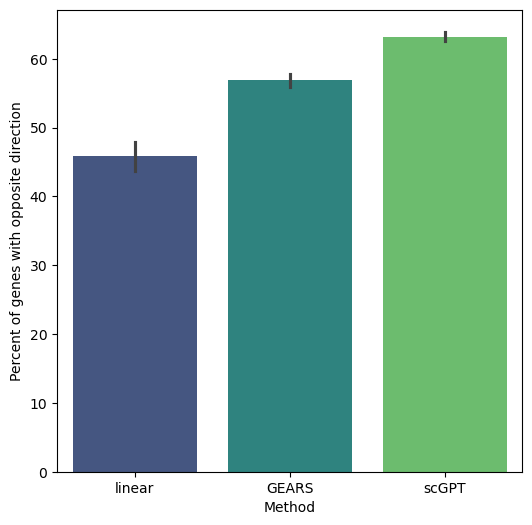

In [110]:
# Initialize a dictionary to store percentages
percent_correct = {"GEARS": [], "scGPT": [], "linear": []}
# Initialize a list to track valid conditions
valid_conditions = []

# Loop over each perturbation / condition
for cond in conditions:
    if cond == 'ctrl':
        continue  # skip control

    # Get all genes that are common between datasets
    all_genes = [g for g in adata.var_names if g in common_genes]

    # Get indices for all common genes
    gene_idx = [adata.var_names.get_loc(g) for g in all_genes]

    # Extract predictions and ground truth (ctrl-subtracted)
    GEARS_pred = adata.layers["GEARS_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    GEARS_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    scGPT_pred = adata.layers["scGPT_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    scGPT_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    linear_pred = adata.layers["linear_ctrl"][adata.obs_names.get_loc(cond), gene_idx]
    linear_gt   = adata.layers["truth_ctrl"][adata.obs_names.get_loc(cond), gene_idx]

    # Compute the percentage of predictions in the correct direction
    percent_correct["GEARS"].append(
        np.mean(np.sign(GEARS_pred) == np.sign(GEARS_gt)) * 100
    )
    percent_correct["scGPT"].append(
        np.mean(np.sign(scGPT_pred) == np.sign(scGPT_gt)) * 100
    )
    percent_correct["linear"].append(
        np.mean(np.sign(linear_pred) == np.sign(linear_gt)) * 100
    )

    valid_conditions.append(cond)  # Add to valid conditions

# Compute the percentage of predictions in the opposite direction
percent_opposite = {
    "GEARS": [100 - val for val in percent_correct["GEARS"]],
    "scGPT": [100 - val for val in percent_correct["scGPT"]],
    "linear": [100 - val for val in percent_correct["linear"]]
}

# Convert to DataFrame for plotting
percent_opposite_df = pd.DataFrame(percent_opposite, index=valid_conditions)

# Melt to long format for plotting
percent_opposite_long = percent_opposite_df.reset_index().melt(
    id_vars='index',
    value_vars=['GEARS', 'scGPT', 'linear'],
    var_name='method',
    value_name='Percent Opposite'
)

# --- Plotting ---
plt.figure(figsize=(6, 6))
sns.barplot(
    data=percent_opposite_long,
    x="method",
    y="Percent Opposite",
    order=["linear", "GEARS", "scGPT"],
    palette="viridis"
)
plt.ylabel("Percent of genes with opposite direction")
plt.xlabel("Method")
plt.show()